In [244]:
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [251]:
import os
import logging

logger = logging.getLogger(__name__)
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] \t %(message)s",
    datefmt="%b %d %Y %I:%M%p",
)

os.chdir("../")

In [252]:
from src.utils import *
from src.etl import *
from src.rfm import *
import numpy as np
import matplotlib.pyplot as plt
import PyPDF2

In [253]:
logger.info("test")

Mar 01 2023 12:55PM [INFO] 	 test


In [254]:
# get current directory
os.getcwd()

'/Users'

In [255]:
# get all urls to make all datasets
import re

def clean_url(x):
    search = re.findall(r'"(.*?)"', x)
    if search:
        return search[0]
    else:
        return ""

urls = list(filter(lambda x: len(x) > 0, map(clean_url, open("/Users/rohitmishra/ml-theory-capstone/src/urls.txt", "r").readlines())))


In [262]:

# Pdf dataset
#pdf_fp = "/Users/rohitmishra/Desktop/1984.pdf"
pdf_fp = "/Users/rohitmishra/Desktop/Interview Frameworks & Tips from a Google PM (Berkeley).pdf"
pdf_tokenized = pdf_tokenizer(pdf_fp,contextsize=256)


Mar 01 2023 12:59PM [INFO] 	 Unknown characters: {37, 39, 47, 91, 93}


In [263]:
pdf_tokenized.shape

(107, 256, 50)

In [ ]:
make_all_datasets(urls)

In [12]:
corpus = generate_corpus()

Feb 28 2023 05:43PM [INFO] 	 Unknown characters: {64, 34, 37, 39, 42, 47, 91, 93}
Feb 28 2023 05:43PM [INFO] 	 Unknown characters: {91, 93}
Feb 28 2023 05:43PM [INFO] 	 Unknown characters: {91, 93}
Feb 28 2023 05:43PM [INFO] 	 Unknown characters: {91, 93}
Feb 28 2023 05:43PM [INFO] 	 Unknown characters: {91, 93}
Feb 28 2023 05:43PM [INFO] 	 Unknown characters: {39, 42, 91, 60, 93}
Feb 28 2023 05:43PM [INFO] 	 Unknown characters: {34, 91, 93, 39}


In [9]:
vocab = build_vocab()

In [150]:
reverse_vocab = {i: v for v, i in vocab.items()}

In [264]:
def decode(X):
    """Decodes a (N, context_size, vocab_size) array of one-hot vectors into a list of words.)"""
    return [[reverse_vocab[np.argmax(x)] for x in sentence] for sentence in X]

In [265]:
#decoded_corpus = decode(corpus)
decoded_corpus = decode(pdf_tokenized)
#pdf_decoded_corpus = decode(pdf_tokenized)

In [266]:
#corpus = corpus.reshape(-1, len(vocab)*64)
corpus = pdf_tokenized.reshape(-1, len(vocab)*64)

In [267]:
corpus.shape

(428, 3200)

## Baseline: Bigrams/Trigrams

In [268]:
from nltk.util import bigrams, trigrams, pad_sequence
from nltk.lm.preprocessing import padded_everygram_pipeline, flatten
from nltk.lm import MLE

In [269]:
CONTEXT_SIZE = 64
TEST_SPLIT = 0.2

In [270]:
train_corpus = np.array(decoded_corpus[: int(len(decoded_corpus) * (1 - TEST_SPLIT))])
test_corpus = np.array(decoded_corpus[int(len(decoded_corpus) * (1 - TEST_SPLIT)) :])

In [271]:
len(train_corpus), len(test_corpus)

(85, 22)

In [272]:
# shop the dataset in 3/4 - 1/4 split. The 3/4 will be used to conditionally generate the 1/4
CONTEXT_SPLIT_SIZE = int(3/4 * CONTEXT_SIZE)
X_train = train_corpus[:, :CONTEXT_SPLIT_SIZE]
y_train = train_corpus[:, CONTEXT_SPLIT_SIZE:]
X_test = test_corpus[:, :CONTEXT_SPLIT_SIZE]
y_test = test_corpus[:, CONTEXT_SPLIT_SIZE:]

In [273]:
np.where(X_train.flatten() == "<UNK>")[0].shape

(3,)

In [274]:
# get ngrams
ngrams = []
for sent in X_train:
    ngrams.append(list(bigrams(sent)))


In [275]:
lm = MLE(3)
lm.fit(ngrams, vocab)

In [276]:
X_train[:10]

array([['i', 'n', 't', 'e', 'r', 'v', 'i', 'e', 'w', ' ', 'r', 'e', 's',
        'o', 'u', 'r', 'c', 'e', 's', ' ', '1', ' ', ' ', ' ', 'i', 'n',
        't', 'e', 'r', 'v', 'i', 'e', 'w', ' ', 'r', 'e', 's', 'o', 'u',
        'r', 'c', 'e', 's', ' ', 't', 'h', 'e', 'r'],
       ['e', 's', ' ', 'a', 'r', 'e', ' ', 'c', 'a', 't', 'e', 'g', 'o',
        'r', 'i', 'z', 'e', 'd', ' ', 'b', 'a', 's', 'e', 'd', ' ', 'o',
        'n', ' ', 't', 'h', 'e', ' ', ' ', ' ', 't', 'y', 'p', 'e', ' ',
        'o', 'f', ' ', 'i', 'n', 't', 'e', 'r', 'v'],
       ['n', 'd', ' ', 'r', 'e', 's', 'o', 'u', 'r', 'c', 'e', 's', ' ',
        'e', 's', 't', 'i', 'm', 'a', 't', 'i', 'o', 'n', ' ', 'a', 'n',
        'd', ' ', 'a', 'n', 'a', 'l', 'y', 't', 'i', 'c', 'a', 'l', ' ',
        ' ', ' ', 'f', 'r', 'a', 'm', 'e', 'w', 'o'],
       ['i', 's', ' ', 'i', 's', ' ', 'y', 'o', 'u', 'r', ' ', 'b', 'e',
        's', 't', ' ', 'b', 'e', 't', '.', ' ', 'f', 'r', 'o', 'm', ' ',
        'p', 'r', 'o', 'd', 'u', 'c

In [277]:
def generate_text(lm, X_test, length=CONTEXT_SIZE-CONTEXT_SPLIT_SIZE):
    # generate text
    text = []
    for sent in X_test:
        text.append(lm.generate(length, text_seed=sent))
    return text

In [278]:
y_test.shape

(22, 208)

In [279]:
y_test_pred = np.array(generate_text(lm, X_test))

In [280]:
"".join(y_test[0]), "".join(y_test_pred[0])

('s relating   to things like the company (e.g. what are their strengths and weaknesses),   customers (e.g. what are current consumer trends), and competitors (e.g. do we   need to consider a red ocean or blue ',
 'anond<UNK>thisiscthi')

In [281]:
lm.vocab.unk_label

'<UNK>'

In [282]:
class Vocab():
    def __init__(self, vals):
        self._dict = {v: i for i, v in enumerate(vals)}
        self._dict['<UNK>'] = len(self._dict)
        self.rev = {i: v for v, i in self._dict.items()}
    
    def __getitem__(self, key):
        if key in self._dict:
            return self._dict[key]
        else:
            return self._dict['<UNK>']
    
    def __len__(self):
        return len(self._dict)
    
    def __iter__(self):
        return iter(self._dict)
    
    def __contains__(self, key):
        return key in self._dict
    
    def __repr__(self):
        return f"{self.__class__.__name__}({self._dict})"
    
    def decode(self, idx):
        return self.rev[idx]

In [283]:
train_vocab = Vocab(list(sorted(lm.vocab.counts.keys())))
train_vocab

Vocab({' ': 0, '!': 1, '&': 2, '(': 3, ')': 4, ',': 5, '-': 6, '.': 7, '0': 8, '1': 9, '2': 10, '3': 11, '4': 12, '5': 13, '6': 14, '7': 15, '8': 16, '9': 17, ':': 18, ';': 19, '<UNK>': 50, '?': 21, '_': 22, 'a': 23, 'b': 24, 'c': 25, 'd': 26, 'e': 27, 'f': 28, 'g': 29, 'h': 30, 'i': 31, 'j': 32, 'k': 33, 'l': 34, 'm': 35, 'n': 36, 'o': 37, 'p': 38, 'q': 39, 'r': 40, 's': 41, 't': 42, 'u': 43, 'v': 44, 'w': 45, 'x': 46, 'y': 47, 'z': 48, '’': 49})

In [284]:
def encode(sent, vocab=train_vocab):
    return np.array([vocab[w] for w in sent])

def evaluate(y_test, y_test_pred):
    # evaluate
    bleu = []
    perplexity = []
    for i in range(len(y_test)):
        bleu.append(utils.bleu_score([y_test[i]], y_test_pred[i], n=2))
        perplexity.append(utils.perplexity(encode(y_test_pred[i])))
    return { "bleu2": np.mean(bleu), "perplexity": np.mean(perplexity) }

In [285]:
list(map(lambda x: "".join(x), y_test_pred))

['anond<UNK>thisiscthi',
 'alizes,<UNK>omaponan',
 'e<UNK>w<UNK>be<UNK><UNK>t<UNK>in<UNK>e<UNK>i',
 'os<UNK>lumpascow<UNK>o<UNK>e',
 'gn<UNK>fatrve<UNK>g<UNK>ie<UNK>m',
 'erts<UNK>on<UNK><UNK>uedr<UNK>co',
 'whey<UNK>pealditures',
 '<UNK>y<UNK>pr<UNK>thaltistor',
 'nioviditiodue<UNK>w<UNK>',
 'fu<UNK>gemprsoupervo',
 'lis<UNK>mm<UNK>re<UNK>icore<UNK>',
 'rerodutiow<UNK>hilyo',
 '<UNK>arevecrsim<UNK>yont',
 'ercherk<UNK>covetow<UNK>',
 'kef<UNK>tearshacan<UNK>a',
 'ongroutide<UNK>gh<UNK>(u',
 'cuericouse<UNK>yi<UNK>go',
 ').<UNK>plenal<UNK>merthi',
 '<UNK>ings<UNK>grommewh<UNK>f',
 'ifundu<UNK>maly<UNK>thon',
 'dere<UNK>lvercrioll<UNK>',
 'eongnghethe<UNK>qurc']

In [286]:
evaluate(y_test, y_test_pred)

{'bleu2': 3.466543610286562e-06, 'perplexity': 15.502932604112424}

## Laplacian Kernel

In [287]:
# replace each token with its index in the vocab
X_train_enc = np.array([encode(sent) for sent in X_train])
y_train_enc = np.array([encode(sent) for sent in y_train])
X_test_enc = np.array([encode(sent) for sent in X_test])
y_test_enc = np.array([encode(sent) for sent in y_test])

In [288]:
train_vocab = vocab

In [289]:
len(vocab)

50

In [290]:
corpus.shape

(428, 3200)

In [291]:
SUBSET_SIZE = 1000

In [292]:
# randomly subset data
subset = np.random.choice(corpus.shape[0], SUBSET_SIZE, replace=True)

subset_corpus = corpus[subset]

In [293]:
train_data = subset_corpus[: int(len(subset_corpus) * (1 - TEST_SPLIT))]
test_data = subset_corpus[int(len(subset_corpus) * (1 - TEST_SPLIT)) :]

train_data.shape, test_data.shape

((800, 3200), (200, 3200))

In [294]:
KERNEL_SPLIT_SIZE = int(3/4 * CONTEXT_SIZE)

X_train_enc = train_data[:, :CONTEXT_SPLIT_SIZE*len(vocab)].astype("float32")
y_train_enc = train_data[:, CONTEXT_SPLIT_SIZE*len(vocab):].astype("float32")
X_test_enc = test_data[:, :CONTEXT_SPLIT_SIZE*len(vocab)].astype("float32")
y_test_enc = test_data[:, CONTEXT_SPLIT_SIZE*len(vocab):].astype("float32")

X_train_enc.shape, y_train_enc.shape, X_test_enc.shape, y_test_enc.shape

((800, 2400), (800, 800), (200, 2400), (200, 800))

In [295]:
from functools import partial

In [296]:
next_char_train = y_train_enc[:, :len(train_vocab)]
next_char_test = y_test_enc[:, :len(train_vocab)]

In [297]:
# train a laplace kernel
lam = 1e-3
kernel = partial(utils.K_laplace_mat, gamma=0.001)

K = kernel(X_train_enc, X_train_enc)
alpha_hat = np.linalg.solve(K + lam * np.eye(K.shape[0]), next_char_train)

In [298]:
yhat = kernel(X_test_enc, X_train_enc) @ alpha_hat
yhat

array([[ 1.23859540e-02,  3.41535005e-03,  2.90587553e-03, ...,
         0.00000000e+00,  0.00000000e+00,  3.98875787e-04],
       [-1.95546338e-03,  1.11560714e-03, -1.33987685e-04, ...,
         0.00000000e+00,  0.00000000e+00,  1.11030644e-04],
       [-2.62758452e-03, -1.49127696e-03,  9.89350851e-01, ...,
         0.00000000e+00,  0.00000000e+00,  7.86551812e-04],
       ...,
       [-4.54385809e-03,  3.13425525e-04,  3.94371077e-04, ...,
         0.00000000e+00,  0.00000000e+00,  1.68156307e-03],
       [-9.57488136e-04, -2.55868360e-04,  2.46520145e-04, ...,
         0.00000000e+00,  0.00000000e+00, -1.02443817e-04],
       [ 2.16882890e-03,  3.48512868e-05,  3.34871816e-04, ...,
         0.00000000e+00,  0.00000000e+00,  8.76293908e-05]])

In [299]:
(next_char_test.argmax(axis=1) == yhat.argmax(axis=1)).mean()

0.855

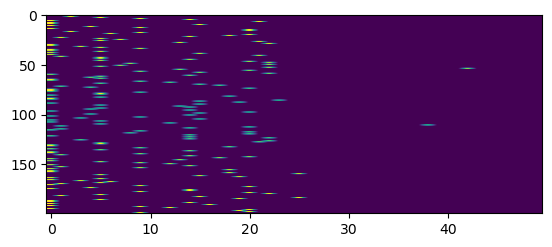

In [300]:
max_index = np.argmax(yhat, axis=1)
yhat[np.arange(yhat.shape[0]), max_index] = 1
yhat[yhat != 1] = 0
plt.imshow(yhat, aspect=0.1)

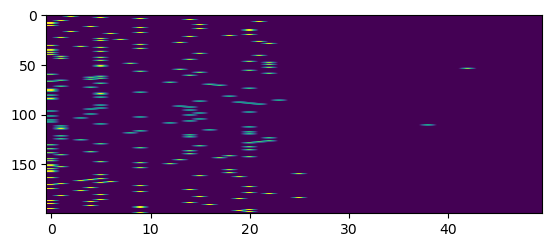

In [301]:
# plot next_char_train, with a good aspect ratio
plt.imshow(next_char_test, aspect=0.1)

In [302]:
yhat_train = kernel(X_train_enc, X_train_enc) @ alpha_hat

(next_char_train.argmax(axis=1) == yhat_train.argmax(axis=1)).mean()

1.0

In [303]:
def generate_text_kernel(kernel, alpha_hat, X, z, length=16):
    text = []
    for i in range(length):
        yhat = kernel(X, z) @ alpha_hat
        # decode the text
        text.append([reverse_vocab[y] for y in np.argmax(yhat, axis=1)])
        # move the window forward
        X = np.concatenate([X[:, len(train_vocab):], yhat], axis=1)
    
    transpose = list(zip(*text))
    return transpose

In [304]:
generated_test = generate_text_kernel(kernel, alpha_hat, X_test_enc, X_train_enc, length=CONTEXT_SIZE-CONTEXT_SPLIT_SIZE)

In [306]:
list(map(lambda x: "".join(x), generated_test))

['ieeietn leese ei',
 'hie tite e  eeit',
 'bu   r sl toeeoi',
 'e oootnese<UNK>tee o',
 'ieeietn leese ei',
 'nre etnoicwe net',
 ' s o th ereu l i',
 'u  enes esel r t',
 '  teera  t eto t',
 ' tnaet  icsd   e',
 'o tnee estteiae ',
 ' u ee iae   ette',
 'd  e itne   e  a',
 'i mt  t e   toe ',
 ' te tnsu  eues o',
 't etess ee r i e',
 'tt     peetieuee',
 'bu   r sl toeeoi',
 'iin eeee sitirs ',
 'f  eop nerae    ',
 'tdesei ets o mis',
 'rtoaonee tore et',
 'ni  eie  eotinee',
 'aieere s dres i ',
 'ese e  to ttiso ',
 'g dsete  ioinei ',
 'ewivet etsn aee ',
 'uoceoi i ee c ie',
 'mnes ide   etnes',
 'veriee  t atm ue',
 ' uar peti e   er',
 ' poennm e eewote',
 'cettnl teerem te',
 'ese e  to ttiso ',
 'i    esni   aesl',
 '  e nse en roe g',
 ' ireg e e tun ts',
 'etitt   eit0eieo',
 '   otmm e tle to',
 'onest t t eede n',
 ' detietto  isr d',
 'uscenttieleel pe',
 'ang  see  o tnnm',
 'e sletletrofer  ',
 'e  tieene iteieo',
 'nesleeet o t eyp',
 'eesr iri csenevi',
 't evce 

In [307]:
reshaped_y_test = y_test_enc.reshape(-1, CONTEXT_SIZE-CONTEXT_SPLIT_SIZE,len(train_vocab))

y_test_text = ["".join([reverse_vocab[np.argmax(y)] for y in y_test]) for y_test in reshaped_y_test]

len(y_test_text)

200

In [308]:
evaluate(y_test_text, generated_test)

/Users/rohitmishra/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


{'bleu2': 0.20542509154970795, 'perplexity': 11.516435710047304}

## RFM

In [310]:
alpha, M, _ = train_rfm(X_train_enc, next_char_train, L=256, T=3)

1
2
3


In [311]:
y_train_pred = utils.K_M(X_train_enc, X_train_enc, M, L=256) @ alpha

In [312]:
utils.mse(y_train_pred, next_char_train)


0.0003790178524355387

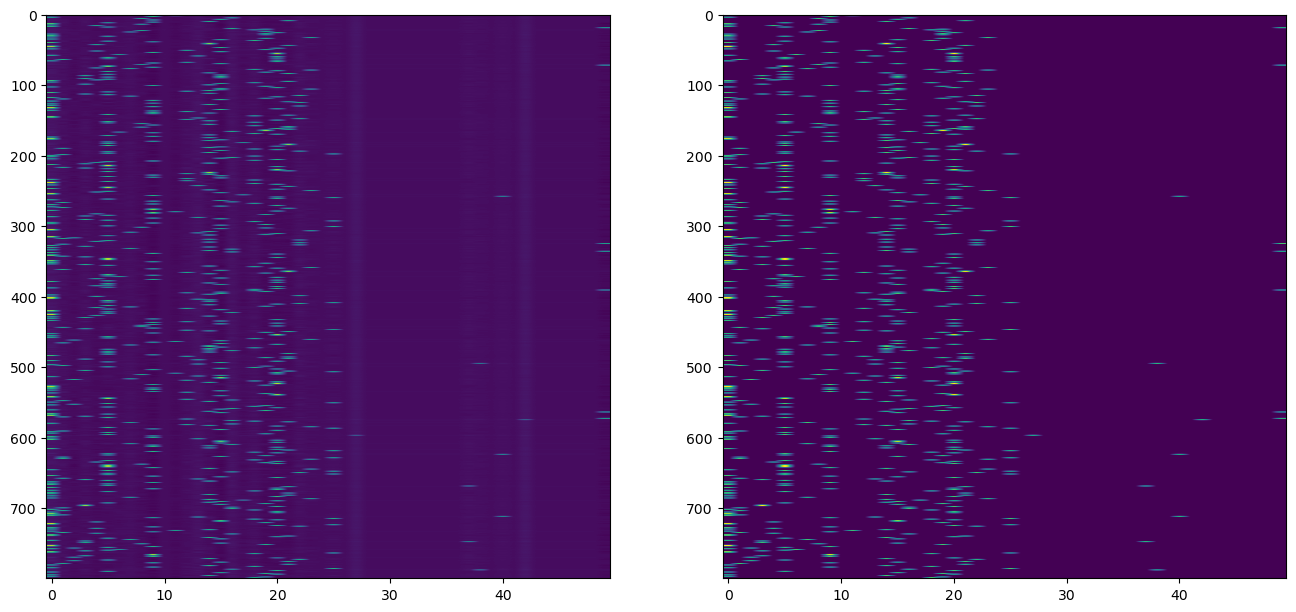

In [313]:
fig, ax = plt.subplots(ncols=2, figsize=(16, 9))
ar = (y_train_pred.shape[1]/y_train_pred.shape[0])
ax[0].imshow(utils.softmax(y_train_pred, axis=1), aspect=ar)
ax[1].imshow(next_char_train, aspect=ar)

In [314]:
y_test_pred = utils.K_M(X_test_enc, X_train_enc, M, L=64) @ alpha

In [315]:
utils.mse(y_test_pred, next_char_test)

0.18575610629463454

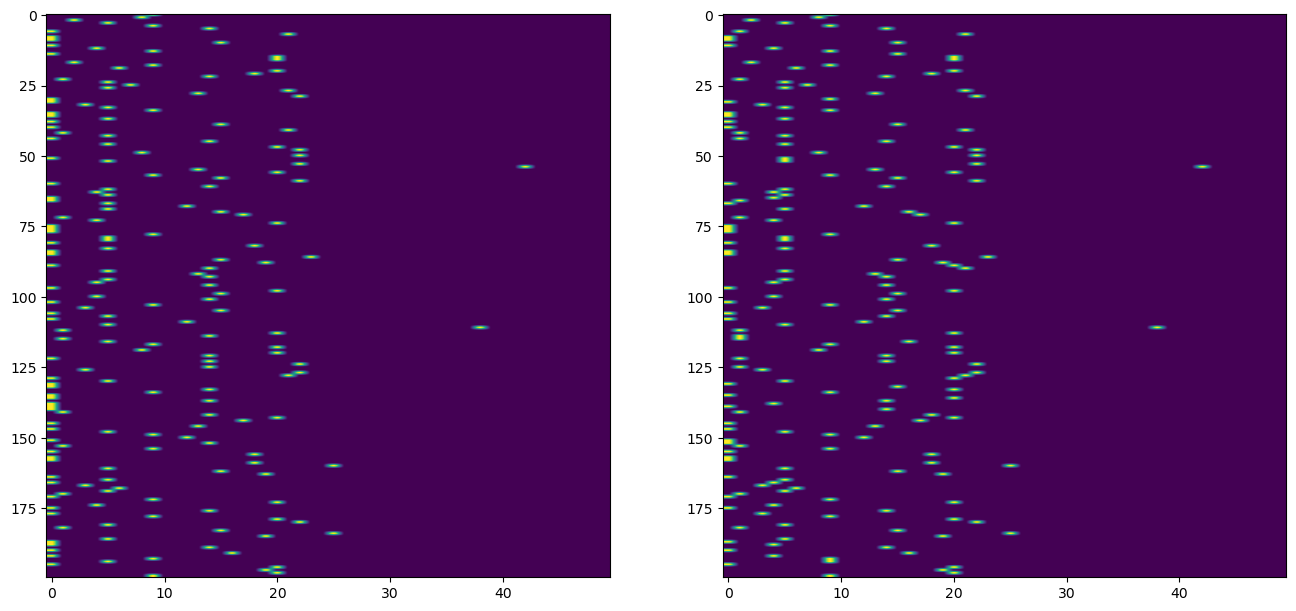

In [316]:
fig, ax = plt.subplots(ncols=2, figsize=(16, 9))
ar = (y_test_pred.shape[1]/y_test_pred.shape[0])
y_test_argmax_ohc = np.eye(len(train_vocab))[y_test_pred.argmax(axis=1)]
ax[0].imshow(y_test_argmax_ohc, aspect=ar)
ax[1].imshow(next_char_test, aspect=ar)

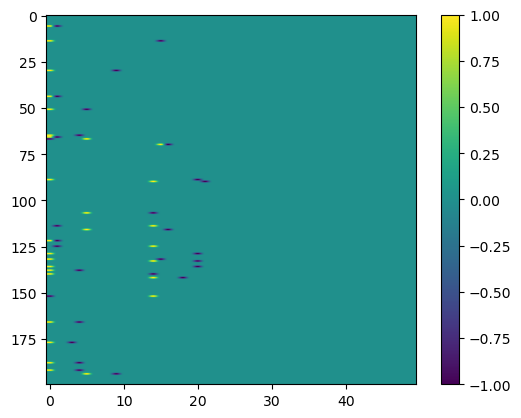

In [317]:
plt.imshow(y_test_argmax_ohc - next_char_test, aspect=ar)
plt.colorbar()

In [318]:
from functools import partial

In [319]:
kernel_rfm = partial(utils.K_M, M=M, L=64)

gen_test_rfm = generate_text_kernel(kernel_rfm, alpha, X_test_enc, X_train_enc, length=CONTEXT_SIZE-CONTEXT_SPLIT_SIZE)

In [320]:
evaluate(y_test_text, gen_test_rfm)

{'bleu2': 0.20500365487938552, 'perplexity': 12.23354038008365}

In [323]:
import random


list(map(lambda x: "".join(x), gen_test_rfm))#[random.randint(0,len(gen_test_rfm))]

['iee  onele st en',
 'hin  teent   see',
 'be  eneeeteeeeae',
 'e  ooene titeeno',
 'iee  onele st en',
 'nte eteoteae eee',
 ' too ih  reatee ',
 'u  enennese  rte',
 '  oeect dd e e e',
 ' toeettei eaneto',
 'ontiee eoeteiee ',
 ' toeetiae eeeeto',
 'd  ooedie  eeteo',
 'innaret ere toer',
 ' eo ene i eateit',
 't e e teneae cie',
 'the aneedeat eoe',
 'be  eneeeteeeeae',
 'itn  ee coi t er',
 'f  eoeine eeteoe',
 'tee eoeede t eoe',
 'r oa ne aoerereo',
 'nt  ereannatieee',
 'ate  e eedars eo',
 'e t eedtoneeere ',
 'g ore eoniseeee ',
 'e tone etsetaee ',
 'ut eoing ee cete',
 'mot  ed aneedney',
 'ver ee eetaot ue',
 ' uon eetiree eet',
 ' toennt  eeenote',
 'cette  teedeca e',
 'e t eedtoneeere ',
 'it   enei   aeer',
 ' to ese  eeaoe t',
 ' toecae e eaniti',
 'e toe deti eemet',
 ' tootnm a teeeto',
 'ones  onc ee ert',
 ' toe ce ddtane o',
 'u  enetie e eene',
 'ats  eeea o teea',
 'e tontie tetereo',
 ' totne eeecteae ',
 'ng tee toe teend',
 'e treeee cetee t',
 'tie ee en,a

In [322]:
# get train and test accuracy
train_acc = (next_char_train.argmax(axis=1) == y_train_pred.argmax(axis=1)).mean()
test_acc = (next_char_test.argmax(axis=1) == y_test_pred.argmax(axis=1)).mean()

print(f"Train accuracy: {train_acc:.2f}")
print(f"Test accuracy: {test_acc:.2f}")

Train accuracy: 1.00
Test accuracy: 0.85


## Bigram Implementation

In [324]:
import random

class NgramModel:
    def __init__(self, n):
        self.n = n
        self.ngrams = {}
        self.total_count = 0

    def update(self, text):
        for i in range(len(text) - self.n):
            ngram = text[i:i+self.n]
            next_char = text[i+self.n]
            if ngram not in self.ngrams:
                self.ngrams[ngram] = {}
            if next_char not in self.ngrams[ngram]:
                self.ngrams[ngram][next_char] = 0
            self.ngrams[ngram][next_char] += 1
            self.total_count += 1

    def predict(self, prefix):
        if prefix not in self.ngrams:
            return random.choice(list(self.ngrams.keys()))[0]
        choices = list(self.ngrams[prefix].items())
        total = sum(count for _, count in choices)
        r = random.uniform(0, total)
        upto = 0
        for choice, count in choices:
            if upto + count >= r:
                return choice
            upto += count
        return choices[-1][0]

    def generate(self, length):
        start = random.choice(list(self.ngrams.keys()))
        text = start
        for i in range(length - self.n):
            prefix = text[-self.n:]
            text += self.predict(prefix)
        return text

In [325]:
pdf_file = open(pdf_fp,"rb")

pdf_reader = PyPDF2.PdfReader(pdf_file)

# Extract text from each page in the PDF file
lines = []

for page in range(len(pdf_reader.pages)):
    page_obj = pdf_reader.pages[page]
    text = page_obj.extract_text()
    lines.extend(text.split('\n'))

# Close the PDF file
pdf_file.close()

In [326]:
# Initialize the model with an n-gram value
model = NgramModel(n=4)

# Update the model with a list of strings

for string in lines:
    model.update(string)

generated_text = []
for i in range(len(y_test_text)):
# Generate text using the model
    generated_text.append(model.generate(16))
    


In [327]:
evaluate(y_test_text, generated_text)

{'bleu2': 0.15421872984425813, 'perplexity': 12.899190729764014}

In [328]:
generated_text

['? Is  nhu !iRent',
 'od process that ',
 'company PM-level',
 ' reduce to the b',
 '. Explain person',
 'e.” These to see',
 'onfidentified ea',
 'e scope are 130 ',
 '. Be clearning. ',
 'n:  Once your in',
 'on Down: State h',
 "gagements: Don't",
 'ma wireframework',
 'onsWebsites a gi',
 'pecially this bo',
 'f likely asked e',
 'ig, strates and ',
 'llectives follow',
 'is make your ste',
 '. Idention (T yl',
 'e “Cases, etc.)?',
 'is section. Peri',
 'ur design  krdeo',
 'Useful for Y ou ',
 'resent created b',
 'nch, your fix it',
 ' \xa0Resources   eu',
 'ly lead to the 5',
 'PM tack, questim',
 'alkthrough conve',
 'is very easy to ',
 'Causes the illus',
 't, types of the ',
 '85% of more both',
 'rk.Interview PDF',
 'By couple trade.',
 'as on what’ s on',
 'e smartphone, an',
 'ulating, possibl',
 ': what are and h',
 'ess is your peer',
 'liers, events an',
 'lements are user',
 'e? While   yctau',
 'y or process mar',
 ', why  2asot?l,i',
 ' , crease Questi',
 'API calc